## Before we begin

Here are versions of the utility functions for 1 and 2 qubits.

In [1]:
from perceval import pdisplay, PS, BS, Circuit, BasicState, Processor, PERM
from perceval.components import Unitary
from perceval.backends import BackendFactory
from perceval.algorithm import Analyzer, Sampler
import perceval as pcvl
from exqalibur import FockState

from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt
from numpy import pi, cos, sin, sqrt
import numpy as np

from typing import List, Dict, Tuple, Union, Optional

qubits = {
    "0": BasicState([1, 0]),
    "1": BasicState([0, 1]),
    "00": BasicState([1, 0, 1, 0]),
    "01": BasicState([1, 0, 0, 1]),
    "10": BasicState([0, 1, 1, 0]),
    "11": BasicState([0, 1, 0, 1])
}
qubits_ = {qubits[k]: k for k in qubits}
sqlist = [qubits["0"], qubits["1"]]
mqlist = [qubits["00"], qubits["01"], qubits["10"], qubits["11"]]

def analyze(circuit: Circuit, input_states: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> None:
    if len(circuit.depths()) == 2:
        states = sqlist
    else:
        states = mqlist

    if input_states is None:
        input_states = states
    if output_states is None:
        output_states = states

    p = Processor("Naive", circuit)
    a = Analyzer(p, input_states, output_states, mapping=qubits_)
    pdisplay(a)

def amplitudes(circuit: Circuit, input_state: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> (complex, complex):
    if input_state is None:
        if len(circuit.depths()) == 2:
            input_state = qubits["0"]
        else:
            input_state = qubits["00"]

    if output_states is None:
        if len(circuit.depths()) == 2:
            output_states = sqlist
        else:
            output_states = mqlist

    b = BackendFactory.get_backend("Naive")
    b.set_circuit(circuit)
    b.set_input_state(input_state)
    return {qubits_[k]: roundc(b.prob_amplitude(k)) for k in output_states}

def measure2p(processor: Processor, input_state: Optional[FockState] = None) -> None:
    if input_state is None:
        input_state = qubits["00"]

    # We enforce the rule: the sum of photons per pair of rails must be equal to 1.
    processor.set_postselection(pcvl.utils.PostSelect("[0,1]==1 & [2,3]==1"))
    processor.min_detected_photons_filter(0)
    
    # Finally, we take the measurement:
    processor.with_input(input_state)
    measure2p_s = pcvl.algorithm.Sampler(processor)

    print(f"Input: {qubits_[input_state]}")
    for k, v in measure2p_s.probs()["results"].items():
        print(f"> {qubits_[k]}: {round(v, 2)}")

def roundc(c, decimals: int = 2):
    return round(c.real, decimals) + round(c.imag, decimals) * 1j

![dicaprio_laugh_meme.jpg](memes/challenge_3-english.jpg)

## Multiple Systems

The concepts discussed for simple systems, *concatenation of gates, measurements, probabilities*..., are still valid for **multiple systems**. To add a qubit, you will need to apply **tensor products to the gates** as well as to the basis states.

Suppose we have a qubit $A$ and a qubit $B$, respectively in states $|\psi\rangle$ and $|\phi\rangle$. Then the system $(A, B)$ is in the state $|\psi\rangle \otimes |\phi\rangle = |\psi \otimes \phi\rangle$ (depending on the writing conventions).

The canonical basis then becomes:
$$
|00\rangle = |0\rangle \otimes |0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}\otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix}
1 \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\ 
0 \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} 
\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0  \end{pmatrix},
$$
$$
|01\rangle = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0  \end{pmatrix}, 
$$
$$
|10\rangle = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0  \end{pmatrix},
$$
$$
|11\rangle = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1  \end{pmatrix}
$$

It's the same for logic gates: **if we apply $U_1$ to $A$ and $U_2$ to $B$, then we apply $U_1 \otimes U_2$ to $A \otimes B$.**

For example, if we apply $H$ to $|0\rangle$ and nothing (i.e., the identity) to $|1\rangle$. The matrix of the operation on the system is thus $H \otimes I$. The circuit is as follows:

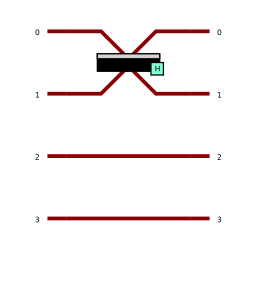

In [2]:
c = Circuit(4) // (0, BS.H())
pdisplay(c)

We expect to have: 
$$
\DeclareMathOperator{\H}{H}
\DeclareMathOperator{\I}{I}
$$

$$
|0\rangle \otimes |1\rangle \rightarrow \begin{cases} 
    \text{Top: } |0\rangle \longrightarrow \H \longrightarrow \frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \\
    \text{Bottom:  } |1\rangle \longrightarrow \I \longrightarrow |1\rangle
\end{cases} \rightarrow \left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\otimes|1\rangle 
$$

This gives the state: 
$$
\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\otimes|1\rangle = \frac{1}{\sqrt{2}}|01\rangle+\frac{1}{\sqrt{2}}|11\rangle
$$

In practice, we determine the logic gate $U$, where $U = H \otimes I$, so:
$$
U = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1& -1\end{pmatrix} \otimes \begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}&1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}\\1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}&-1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix} \end{pmatrix}= \frac{1}{\sqrt{2}}\begin{pmatrix} 1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix}
$$

This gives us with our input: 
$$
|01\rangle = \begin{pmatrix} 0\\1\\0\\0\end{pmatrix}, 
$$
$$
\frac{1}{\sqrt{2}}\begin{pmatrix} 1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix} \begin{pmatrix} 0\\1\\0\\0\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 0\\1\\0\\1\end{pmatrix} = \frac{1}{\sqrt{2}} |01\rangle + \frac{1}{\sqrt{2}} |11\rangle
$$

Which corresponds exactly to the expected result.

*If you would like a more detailed explanation, you can check out this course offered by IBM: https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems.*

### Quantum Entanglement

A very interesting property of qubits is that they can be separated, but also **entangled**, meaning they are dependent on each other. This allows, for example, to act on one qubit and obtain information about the second one.

If we take the entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$, and we measure the first qubit (we have a 50% chance of getting $0$ and correspondingly $1$), the state of the second qubit is entirely determined without measuring it! Indeed, if we measure $0$ for the first qubit, then the second is necessarily also $0$. However, since the measurement of the first qubit is random, this does not allow information to be teleported faster than the speed of light, as from the other perspective, one does not know the state of the measurement (before receiving the information through a classical channel, for example).

A counterexample is the state $|\psi\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle) = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Measuring the first qubit does not give any information about the second; the two qubits are **independent** or **separable**.

### The Controlled-NOT (CNOT) Gate

The flagship gate of quantum entanglement is the controlled NOT gate (or CNOT or cX). It acts on 2 qubits, and **performs the NOT operation on the second qubit only when the first qubit is $|1\rangle$, otherwise it leaves it unchanged**. Its matrix is as follows:

$$
\DeclareMathOperator{\CNOT}{CNOT}
$$

$$
\CNOT = \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{pmatrix}
$$
Ou encore : 
$$
\CNOT = 
\begin{cases}
    |00 \rangle \xrightarrow[]{I \otimes I} |00 \rangle \\
    |01 \rangle \xrightarrow[]{I \otimes I} |01 \rangle \\
    |10 \rangle \xrightarrow[]{I \otimes NOT} |11 \rangle \\
    |11 \rangle \xrightarrow[]{I \otimes NOT} |10 \rangle 
\end{cases}
$$

Its implementation with photons is quite technical, and it hides problems related to our way of encoding qubits. Therefore, we will rely on the definition proposed by Quandela to use this gate in our circuits.

In [3]:
from perceval.components import catalog
cnot = catalog["klm cnot"].build_circuit()
# https://github.com/Quandela/Perceval/blob/main/perceval/components/core_catalog/klm_cnot.py

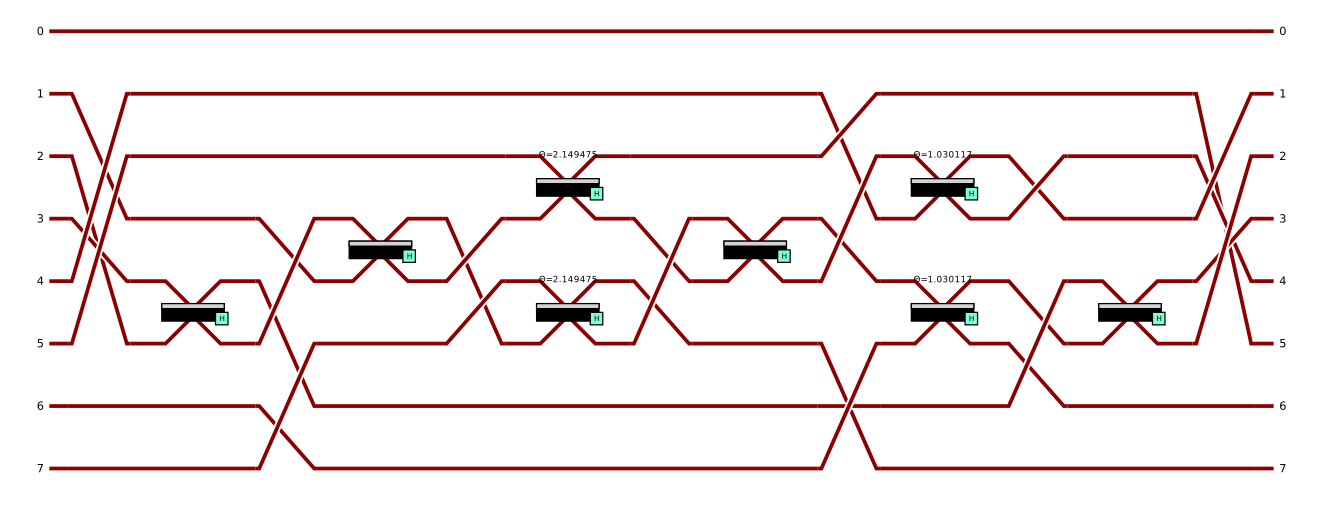

In [4]:
pdisplay(cnot)

### One last point before we go

As you have seen, the CNOT gate defined above **involves 8 rails instead of the expected 4**. This is where the technical peculiarity related to photonics lies. For our encoding to work, **the sum of the photons in a pair of rails must be equal to 1**.

For example, for the state $|01\rangle$, we have $1$ photon in the first rail, $0$ in the second and third rails, and $1$ in the fourth rail. If we end up with $1$ photon in the second rail and $1$ photon in the third rail at the end, we know we have the state $|10\rangle$. But what happens if we get $2$ photons in the first rail and $0$ in the others? Well, that does not correspond to any logical state. It makes sense physically, but not informatically; we can no longer assign qubits to our photonic state.

To address this issue, we add control states that will nullify certain results. In our case, everything will be handled automatically through heralded gates and ancilla states.

### To summarize:

- We let the heralded gates and ancilla states handle the issues.
- If we end up with an inconsistent number of photons at the end of our experiment, there's no need to overthink it; the experiment is invalid and needs to be redone.

To manage the heralded gates and ancilla states, we will work directly with processors.

*More information here: https://perceval.quandela.net/docs/notebooks/Tutorial.html#3.-Two-qubit-gates*

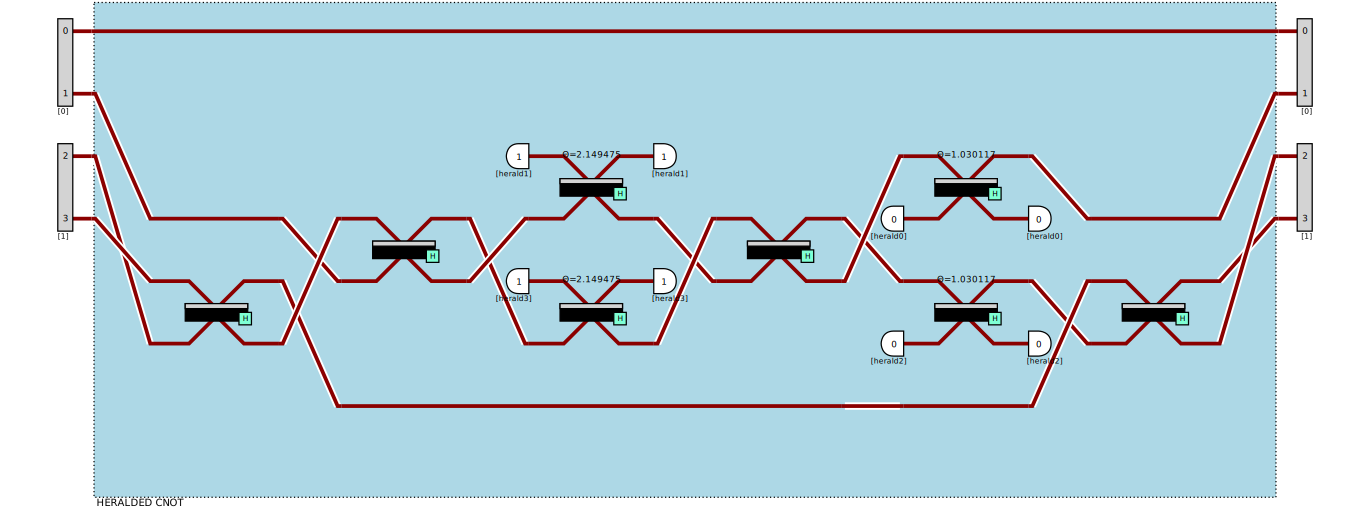

In [5]:
p = Processor("Naive", cnot)
p.min_detected_photons_filter(0)
p.add_herald(4, 0)
p.add_herald(5, 1)
p.add_herald(6, 0)
p.add_herald(7, 1)
p.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p, recursive=True)

In [6]:
measure2p(p)
measure2p(p, input_state=qubits["10"])
measure2p(p, input_state=qubits["01"])
measure2p(p, input_state=qubits["11"])

Avec l'entrée : 00
> 00: 1.0
Avec l'entrée : 10
> 11: 1.0
Avec l'entrée : 01
> 01: 1.0
Avec l'entrée : 11
> 10: 1.0


## Your Turn!

We have seen how to prepare a qubit in any quantum state. Now we will move on to setting up two-qubit states!

To start, let's try to prepare what are called **Bell states**. They are widely used because they correspond to **entangled states** and are relatively easy to manipulate. They correspond to the following basis:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$
$$
|\Phi^-\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)
$$
$$
|\Psi^+\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)
$$
$$
|\Psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle)
$$

Let's try to prepare the state $|\Phi^+\rangle$. A possible approach is as follows: we seek to have a superposed state, so we will need a Hadamard gate or equivalent, and we also need entangled states, so we will need a $\CNOT$ gate. In practice, this results in:

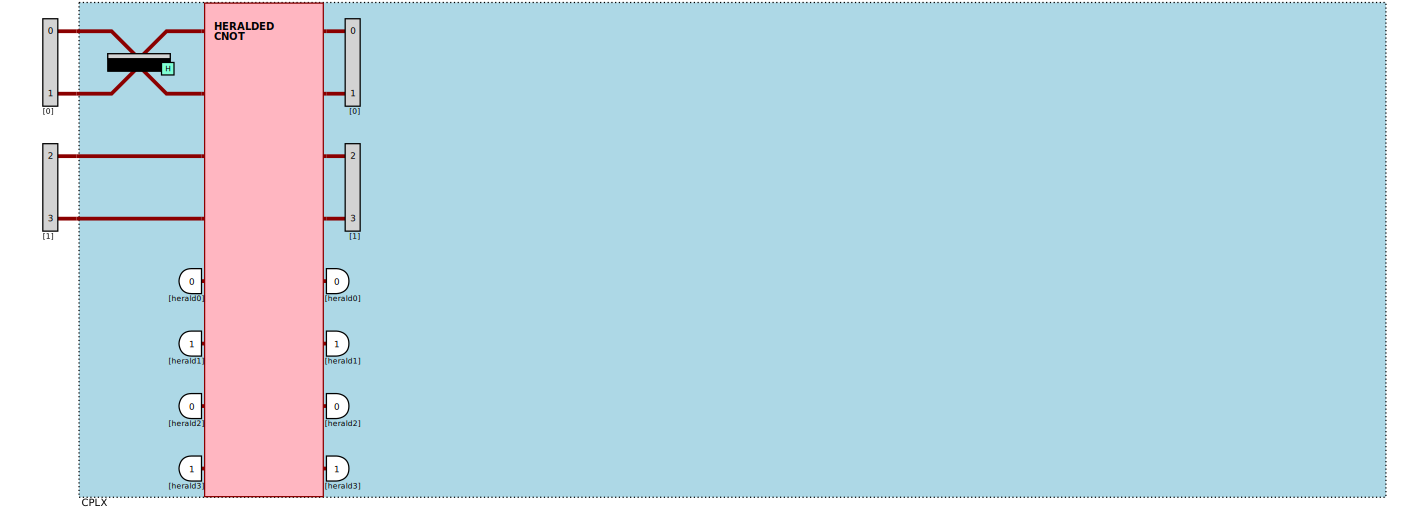

In [7]:
phi_plus = Circuit(8).add(0, BS.H()).add(0, cnot)

# Processor Preparation
p_plus = Processor("Naive", phi_plus)  # Step 1: Create the processor with the correct circuit
p_plus.min_detected_photons_filter(0)       # Step 2: Create the filter to discard failed experiments
p_plus.add_herald(4, 0)                     # Add heralds on rails 4, 5, 6, 7
p_plus.add_herald(5, 1)                     
p_plus.add_herald(6, 0)                     
p_plus.add_herald(7, 1)                     
p_plus.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))  # (Step 4): Optionally specify that we 
p_plus.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))  #      are using rail encoding
pdisplay(p_plus, recursive=True)            # Final step: Admire the result/ cry if it does not work

In [8]:
measure2p(p_plus)

Avec l'entrée : 00
> 00: 0.5
> 11: 0.5


One can also cheat with: 

In [9]:
e = pcvl.utils.stategenerator.StateGenerator(encoding=pcvl.Encoding.DUAL_RAIL)
b = e.bell_state("phi-")
print(b)

-sqrt(2)/2*|0,1,0,1>+sqrt(2)/2*|1,0,1,0>


## Step 1: Creating Quantum States

**1.a)** Create the state:
$$
|\psi\rangle = |11\rangle
$$

Starting from our base state, which is $|00\rangle$. The qubits are accessible via the `qubits` dictionary for testing, although the default input is already $|00\rangle$.

*There are multiple ways to do this. All methods are accepted.*

<h2 style="color:green">Solution Step 1:</h2>

One possibility is as follows:
$$
|00\rangle \xrightarrow{X \text{qubit 0}} |10\rangle \xrightarrow{\CNOT}  |11\rangle
$$

We could also directly apply the NOT gate twice:
$$
|00\rangle \xrightarrow{X \text{qubit 0}} |10\rangle \xrightarrow{X \text{qubit 1}}   |11\rangle
$$

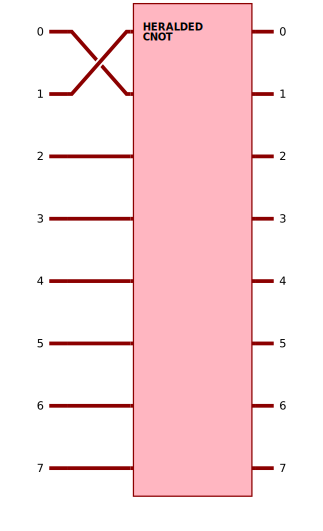

In [10]:
step_one = Circuit(8).add(0, PERM([1, 0])).add(0, cnot)
step_one_double_not = Circuit(4).add(0, PERM([1, 0, 3, 2])) 

pdisplay(step_one)

If you didn't use a CNOT gate, you can verify with:

In [11]:
if len(step_one.depths()) == 4:
    analyze(step_one)
    print(f"Result : {amplitudes(step_one)}")
    print("Solution: {'00': 0j, '01': 0j, '10': 0j, '11': (1+0j)}")

If you used a CNOT gate, you need to set up a processor:

In [12]:
if len(step_one.depths()) == 8:
    p_step_one = Processor("Naive", step_one)
    p_step_one.min_detected_photons_filter(0)
    p_step_one.add_herald(4, 0)
    p_step_one.add_herald(5, 1)
    p_step_one.add_herald(6, 0)
    p_step_one.add_herald(7, 1)
    p_step_one.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
    p_step_one.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
    pdisplay(p_step_one, recursive=True)

In [13]:
measure2p(p_step_one)
print("Solution:\n> 11: 1.0")

Avec l'entrée : 00
> 11: 1.0
Solution :
> 11: 1.0


**1.b)** Create the following state:
$$
|\psi\rangle = -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|11\rangle
$$

<h2 style="color:green">Solution Step 1 bis:</h2>

First, we can try to apply the rotation to rail 0:
$$
|00\rangle \xrightarrow{Ry ~\text{qubit 0}} -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|10\rangle
$$

Then, simply apply a CNOT to achieve the result:
$$
 -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|10\rangle\xrightarrow{CNOT}-\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|11\rangle
 $$

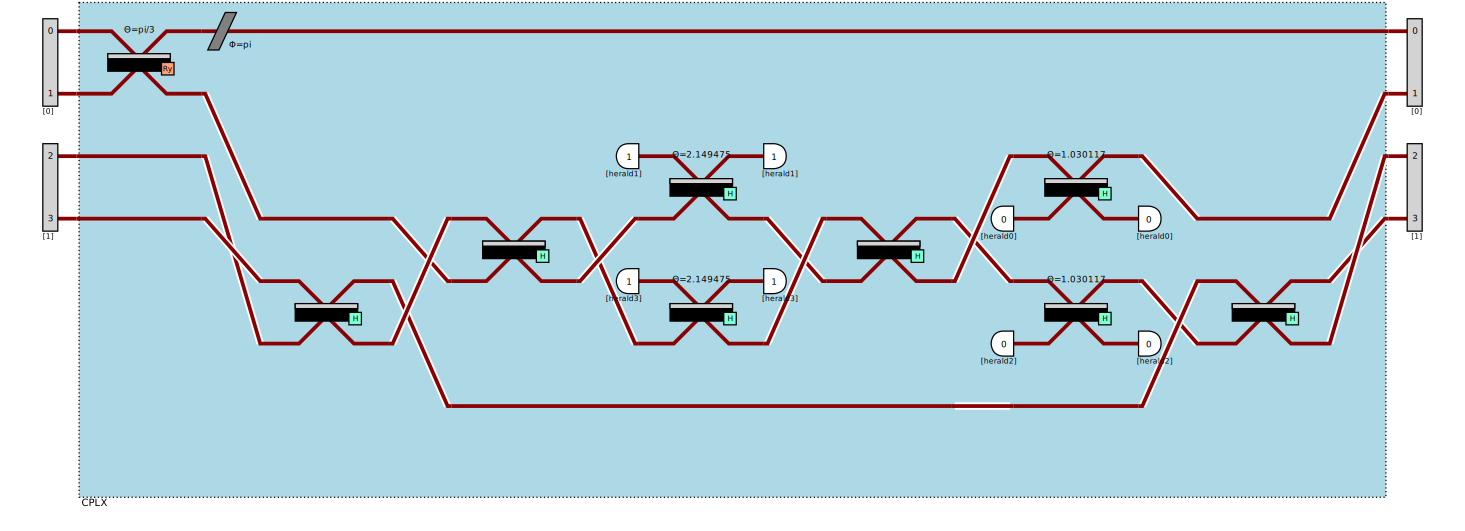

In [14]:
# Be careful with the signs and the factor of 2 related to the implementation of `BS.Ry`:
step_one_more = Circuit(8) // BS.Ry(pi/3) // (0, PS(pi)) // (0, cnot)

p_step_one_more = pcvl.Processor("Naive", step_one_more)
p_step_one_more.min_detected_photons_filter(0)
p_step_one_more.add_herald(4, 0)
p_step_one_more.add_herald(5, 1)
p_step_one_more.add_herald(6, 0)
p_step_one_more.add_herald(7, 1)
p_step_one_more.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_step_one_more.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_step_one_more, recursive=True)

In [15]:
measure2p(p_step_one_more)

Avec l'entrée : 00
> 00: 0.75
> 11: 0.25


## Step 2: Bell States

Once we have successfully created the Bell states, we still need to know how to measure them in order to use them. Similarly to before, to measure in an arbitrary basis $\mathcal{B}$, we will create the transition matrix from $\mathcal{B}$ to $\mathcal{B}_c$, our canonical basis, and then measure in this known basis.

Combine different gates to obtain the basis change gate, from the Bell basis to the canonical basis. The tests are below.

<h2 style="color:green">Solution Step 2:</h2>

We can either invert the transition matrix from the canonical basis to the Bell basis to obtain the matrix that returns to the canonical basis, or we can simply observe that the Hadamard gate **H** is its own inverse and the **CNOT** gate is also its own inverse. This gives us for $|00\rangle$:
$$
|00\rangle \xrightarrow{H ~\text{qubit 0}} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |10\rangle \xrightarrow{CNOT} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |11\rangle \xrightarrow{CNOT} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |10\rangle\xrightarrow{H ~\text{qubit 0}} |00\rangle
$$

In [16]:
step_two = Circuit(8, "Transition Bell -> Canonical") // (0, cnot) // (0, BS.H())

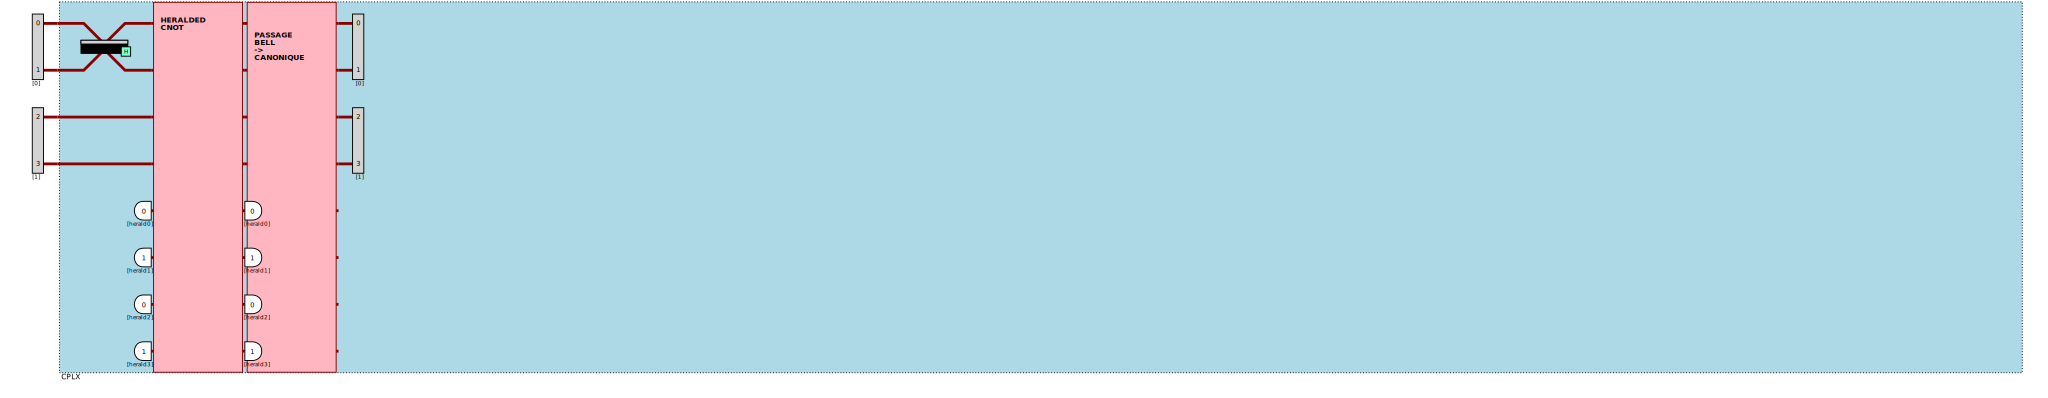

In [17]:
test_passage = Circuit(8).add(0, BS.H()).add(0, cnot).add(0, step_two)
p_test_passage = pcvl.Processor("Naive", test_passage)
p_test_passage.min_detected_photons_filter(0)
p_test_passage.add_herald(4, 0)
p_test_passage.add_herald(5, 1)
p_test_passage.add_herald(6, 0)
p_test_passage.add_herald(7, 1)
p_test_passage.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_test_passage.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_test_passage, recursive=True)

The test circuit transitions to the Bell basis, then returns to the canonical basis. We therefore expect to find the identity (with some rounding errors).

***Warning***, for the moment the tests require the circuit to have 8 rails.

In [18]:
measure2p(p_test_passage)

Avec l'entrée : 00
> 00: 0.96
> 01: 0.02
> 10: 0.02
> 11: 0.0


In [19]:
measure2p(p_test_passage, qubits["01"])

Avec l'entrée : 01
> 00: 0.02
> 01: 0.96
> 10: 0.0
> 11: 0.02


In [20]:
measure2p(p_test_passage, qubits["10"])

Avec l'entrée : 10
> 00: 0.02
> 01: 0.0
> 10: 0.96
> 11: 0.02


In [21]:
measure2p(p_test_passage, qubits["11"])

Avec l'entrée : 11
> 00: 0.0
> 01: 0.02
> 10: 0.02
> 11: 0.96


*It was also possible to create the circuit on 12 rails to avoid reusing the heralds and get exact outputs, but this was not required.*

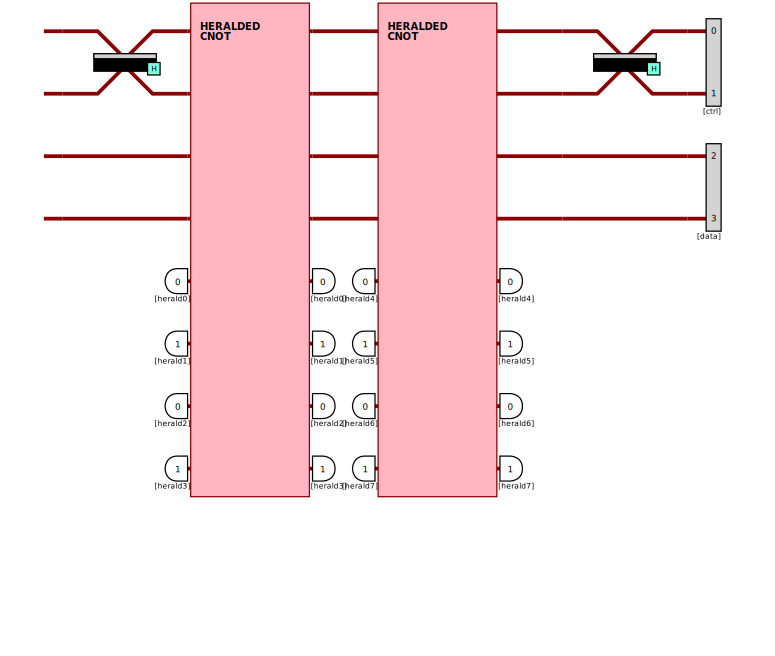

In [22]:
# I am using the processor directly to avoid managing the heralds manually:
CNOT = catalog['klm cnot'].build_processor()
q1, q2 = [0,1], [2,3]

p_better = pcvl.Processor("SLOS",4)
p_better.add(0, BS.H())
p_better.add(q1+q2, CNOT)
p_better.add(q1+q2, CNOT)
p_better.add(0, BS.H())
pcvl.pdisplay(p_better, recursive=False)

In [23]:
measure2p(p_better, qubits["00"])

Avec l'entrée : 00
> 00: 1.0


In [24]:
measure2p(p_better, qubits["01"])

Avec l'entrée : 01
> 01: 1.0


In [25]:
measure2p(p_better, qubits["10"])

Avec l'entrée : 10
> 10: 1.0


In [26]:
measure2p(p_better, qubits["11"])

Avec l'entrée : 11
> 11: 1.0


## Step 3: Trivial?

Create the following state:
$$
|\psi\rangle = \frac{1}{\sqrt{3}}(|01\rangle + |10\rangle + |11\rangle)
$$

<h2 style="color: green">Solution Step 3:</h2>

One possibility for this step is to make an initial split $\left(\frac{1}{\sqrt{3}}/\frac{2}{\sqrt{3}}\right)$, followed by a second conditional split $\left(\frac{1}{\sqrt{3}}/\frac{1}{\sqrt{3}}/\frac{1}{\sqrt{3}}\right)$. To achieve this second conditional split, we need a Hadamard gate that applies to the second qubit only if the first qubit is 1, which is a controlled Hadamard gate (<i>CH</i>).

To construct this gate from basic gates, we can look for the rotation $R_y(\theta)$ such that:
$$
\DeclareMathOperator{\PS}{PS}
$$
$$
R_y(\theta)\PS(\pi)R_y(-\theta) = H
$$
where:
$$
\PS(\theta) = \begin{pmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{pmatrix}
$$
This gives:
$$
\begin{cases}
R_y(\theta)\PS(\pi)R_y(-\theta) = H, \quad\text{if the CNOT is activated} \\
R_y(\theta)I R_y(-\theta) = I, \quad\text{otherwise}
\end{cases}
$$

We just need to find $\theta$ with:
$$
R_y(\theta) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
$$
This gives:
$$
R_y(\theta)\PS(\pi)R_y(-\theta) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\begin{pmatrix}
\cos{\frac{\theta}{2}} & \sin{\frac{\theta}{2}} \\
- \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
=
\begin{pmatrix}
\cos{\theta} & \sin{\theta} \\
\sin{\theta} & -\cos{\theta}
\end{pmatrix}
= H
$$
Thus:
$$
\theta = \frac{\pi}{4}
$$

(For a better explanation, see: https://quantumcomputing.stackexchange.com/questions/15734/how-to-construct-a-controlled-hadamard-gate-using-single-qubit-gates-and-control)


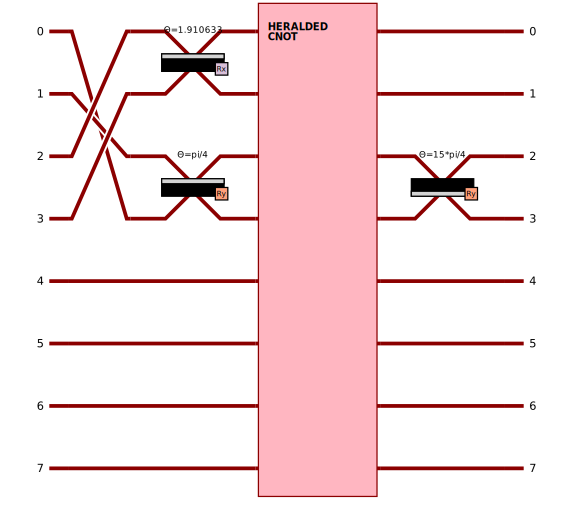

In [27]:
# With a few permutations:
step_three = (Circuit(8).add(0, PERM([3, 2, 0, 1])).add(0, BS(BS.r_to_theta(1/3))).add(2, BS.Ry(pi/4)).add(0, cnot).add(2, BS.Ry(-pi/4)))

pdisplay(step_three)

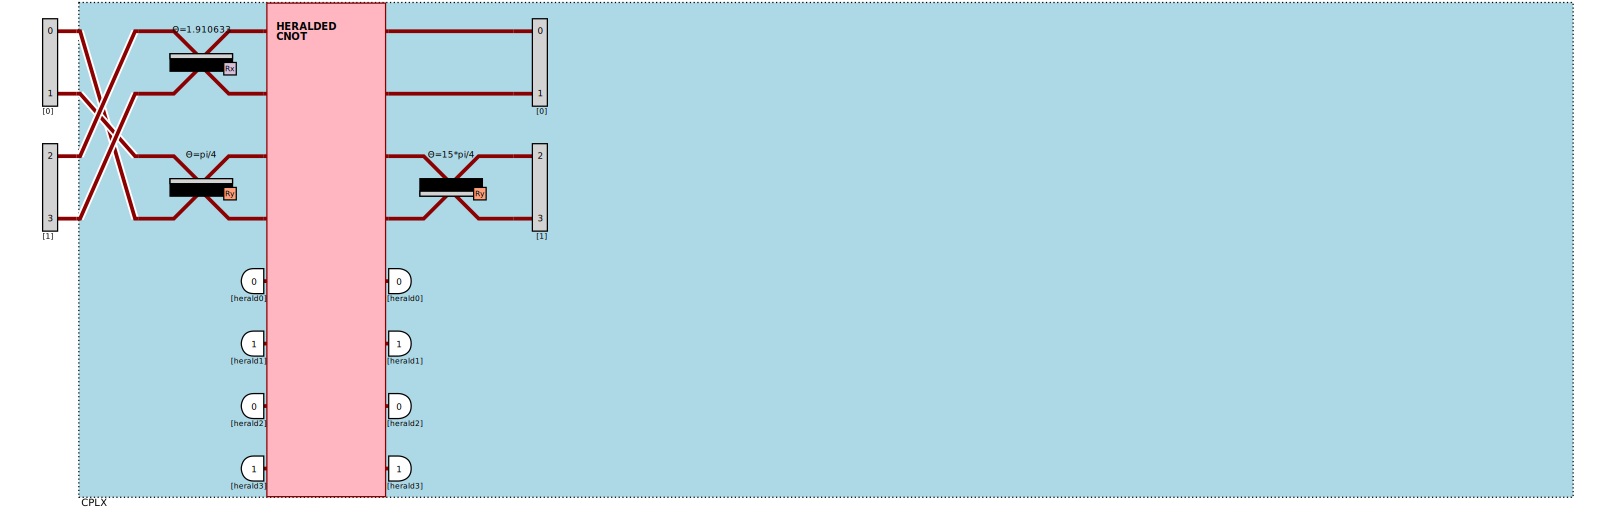

In [28]:
p_step_three = Processor("Naive", step_three)
p_step_three.min_detected_photons_filter(0)
p_step_three.add_herald(4, 0)
p_step_three.add_herald(5, 1)
p_step_three.add_herald(6, 0)
p_step_three.add_herald(7, 1)
p_step_three.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_step_three.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_step_three, recursive=True)

In [29]:
measure2p(p_step_three)

Avec l'entrée : 00
> 01: 0.33
> 10: 0.33
> 11: 0.33


## Flag recovery

In [30]:
def circuit_to_list(circuit: Circuit) -> List[List[Tuple[float, float]]]:
    return [[(x.real, x.imag) for x in l] for l in np.array(circuit.compute_unitary())]

d = {
    "step_one": circuit_to_list(step_one),
    "step_one_more": circuit_to_list(step_one_more),
    "step_two": circuit_to_list(step_two),
    "step_three": circuit_to_list(step_three)
}

In [31]:
import requests as rq

URL = ...
# URL = "https://perceval.challenges.404ctf.fr"
rq.get(URL + "/healthcheck").json()

{'message': 'Statut : en pleine forme !'}

In [32]:
rq.post(URL + "/challenges/3", json=d).json()

{'message': 'GG ! Voici le drapeau : 404CTF{d_Un3_tR1v14l1t3_AbS0lu3}'}

`d_Un3_tR1v14l1t3_AbS0lu3`, *d'une trivialité absolue* means "of absolute triviality..."